In [315]:
#imports
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk import word_tokenize
import spacy 
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()


In [3]:
df = pd.read_csv('sentence_classifications_.csv')

In [4]:
df.head()

,Unnamed: 0,article_id,sentence_char_start,sentence_char_end,propaganda,propaganda_type,text,prop_start_char,prop_end_char,prop_txt_snippet,sent_#
0,0,701225819,0,59,non-propaganda,NaN,South Florida Muslim Leader Sofian Zakkout’s D...,NaN,NaN,NaN,1
1,1,701225819,60,207,propaganda,"Name_Calling,Labeling","David Duke, the white supremacist icon and for...",111.0,143.0,Grand Wizard of the Ku Klux Klan,2
2,2,701225819,207,382,propaganda,Loaded_Language,"However, one individual who represents the Mus...",305.0,313.0,enamored,3
3,3,701225819,382,525,non-propaganda,NaN,"Last month, once again, Zakkout chose to showc...",NaN,NaN,NaN,4
4,4,701225819,525,595,non-propaganda,NaN,The postings can be rivaled only by Zakkout’s ...,NaN,NaN,NaN,5


In [19]:
df_1 = df[df['text'].isna()==False]
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15220 entries, 0 to 15240
Data columns (total 11 columns):
Unnamed: 0             15220 non-null int64
article_id             15220 non-null int64
sentence_char_start    15220 non-null int64
sentence_char_end      15220 non-null int64
propaganda             15220 non-null object
propaganda_type        3840 non-null object
text                   15220 non-null object
prop_start_char        3840 non-null float64
prop_end_char          3840 non-null float64
prop_txt_snippet       3840 non-null object
sent_#                 15220 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.4+ MB


In [5]:
#LOOKING FOR DIFFERENCES IN PROP AND NON PROP FOR CERTAIN WORDS/TOPICS... MIGHT NEED TO CHANGE SOME LABELS

In [23]:
non_prop = df_1[(df_1['propaganda']=='non-propaganda')]
prop = df_1[(df_1['propaganda']=='propaganda')]
print(non_prop[non_prop['text'].str.contains('Arab ')].text)
print(prop[prop.text.str.contains('Arab ')].text)
print(len(non_prop[non_prop.text.str.contains('Arab ')]),len(prop[prop.text.str.contains('Arab ')]))


1616     They floated the idea later Monday of claiming...
9383     Unlike Washington’s Arab allies in the region,...
13995    In Tunisia, the release of WikiLeaks documents...
Name: text, dtype: object
3188     Together they appeared to signal a shift in Wh...
8457     The Nazis suggested Madagascar, Ecuador, or an...
8529             No one defends Islam like Arab Christians
13437    Second, in a reflexive response to 9/11, we in...
Name: text, dtype: object
3 4


## Feature Extraction From Sentences

### Sentence Sentiment Score

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [25]:
def sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt

In [26]:
def sentence_sentiment_score(new_col, transform_col, df):
    df[new_col] = df[transform_col].apply(lambda x: sentiment_scores(x)['compound'])
    return df

In [28]:
df_1 = sentence_sentiment_score('sentiment_score','text',df_1)

/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
df_1.head()

,Unnamed: 0,article_id,sentence_char_start,sentence_char_end,propaganda,propaganda_type,text,prop_start_char,prop_end_char,prop_txt_snippet,sent_#,sentiment_score
0,0,701225819,0,59,non-propaganda,NaN,South Florida Muslim Leader Sofian Zakkout’s D...,NaN,NaN,NaN,1,0.0000
1,1,701225819,60,207,propaganda,"Name_Calling,Labeling","David Duke, the white supremacist icon and for...",111.0,143.0,Grand Wizard of the Ku Klux Klan,2,0.5423
2,2,701225819,207,382,propaganda,Loaded_Language,"However, one individual who represents the Mus...",305.0,313.0,enamored,3,0.3612
3,3,701225819,382,525,non-propaganda,NaN,"Last month, once again, Zakkout chose to showc...",NaN,NaN,NaN,4,0.0000
4,4,701225819,525,595,non-propaganda,NaN,The postings can be rivaled only by Zakkout’s ...,NaN,NaN,NaN,5,0.0000


### Part of Speech Counter

In [354]:
def adj_counter(text):
    text = replace_contractions(text,contr_dict)
#     print(text)
    mytokens = nlp(text)
#     print(mytokens)
    adjs = [word for word in mytokens if word.pos_ == "ADJ"]
#     print(adjs)
    return (len(adjs))

In [355]:
adj_counter('She is a very tall person')

1

In [356]:
prop_adj_count = prop['text'].apply(lambda x: adj_counter(x))
non_prop_adj_count = non_prop['text'].apply(lambda x: adj_counter(x))

In [357]:
print (np.mean(prop_adj_count),np.mean(non_prop_adj_count))

1.8552180863210779 1.1457430126372106


In [360]:
print(np.mean(prop_adj_count/prop_wc),np.mean(non_prop_adj_count/non_prop_wc))

0.0794594126151067 0.06050784886558705


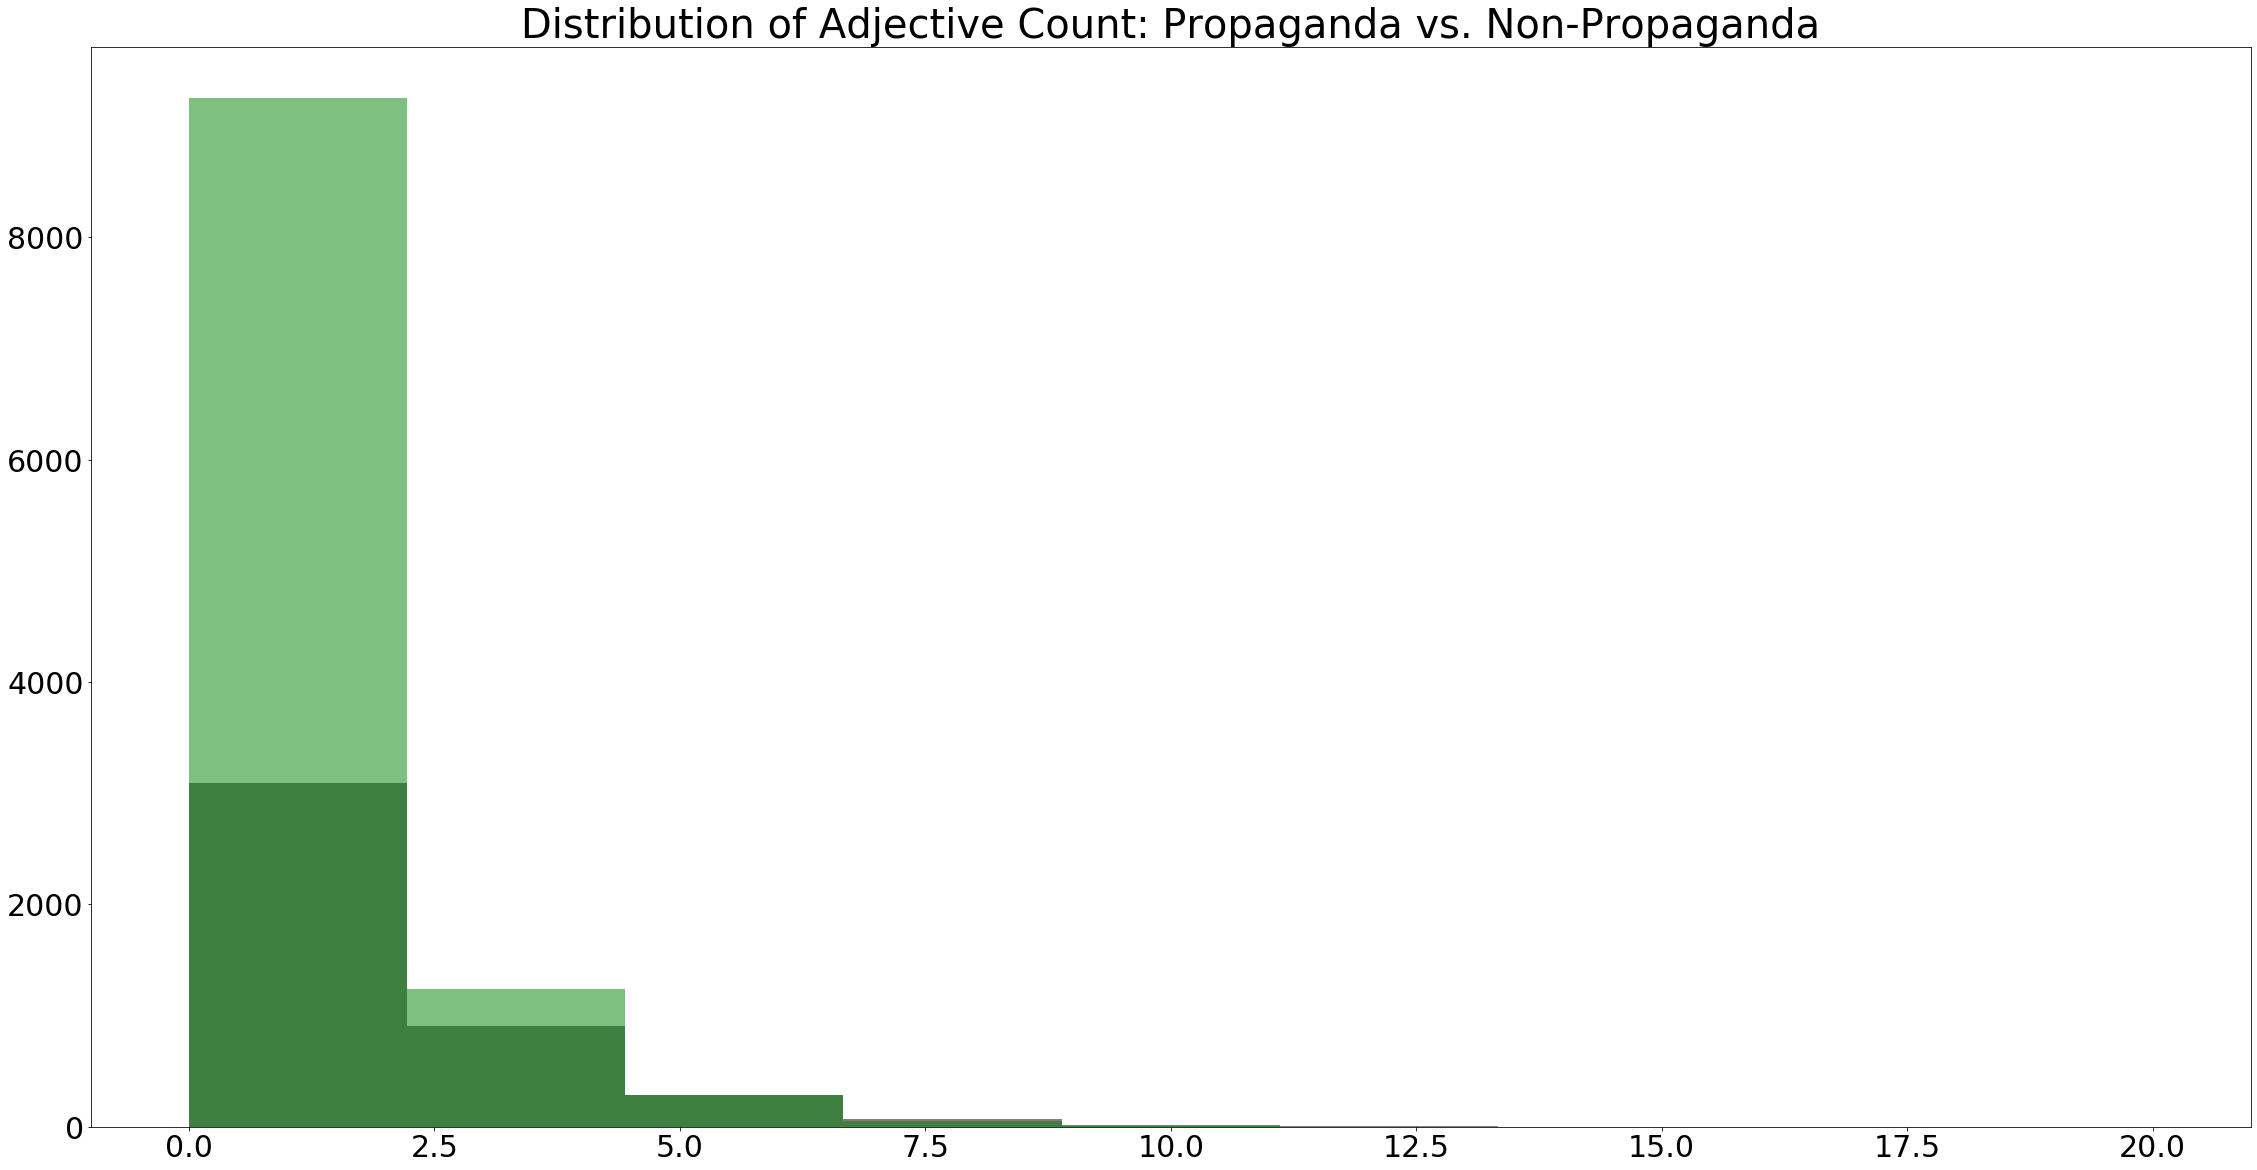

In [359]:
from matplotlib import pyplot
fig_2 = plt.figure(figsize=(30,15))

ax_2 = fig_2.add_axes([0,0,1,1])
bins = numpy.linspace(0, 20, 10)
# prop_sent = prop['sentiment_score'].get_values()
# non_prop_sent = non_prop['sentiment_score'].get_values()

plt.hist(prop_adj_count, bins, alpha=0.5, label='Propaganda', color='black')
plt.hist(non_prop_adj_count, bins, alpha=0.5, label='Non-Propaganda', color='green')
plt.title('Distribution of Adjective Count: Propaganda vs. Non-Propaganda', fontsize=40)
# plt.legend(loc='upper right', fontsize=30)
plt.show()

### Sentence Punctuation Count

In [30]:
import string  
punctuation = string.punctuation

In [31]:
punctuation = punctuation + '”'
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~”'

In [32]:
def count_punct(text):
    count = 0
    for char in text:
        if char in punctuation:
            count +=1
    return count

def count_punct_col(df,transform_col,new_col):
    df[new_col]=df[transform_col].apply(lambda x: count_punct(x))
    return df
    

In [33]:
test_string = 'He said: "HELLO!"... but that is it... no more'
count_punct(test_string)

10

In [35]:
df_1 = count_punct_col(df_1,'text','punct_count')

/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [36]:
df_1.head()

,Unnamed: 0,article_id,sentence_char_start,sentence_char_end,propaganda,propaganda_type,text,prop_start_char,prop_end_char,prop_txt_snippet,sent_#,sentiment_score,punct_count
0,0,701225819,0,59,non-propaganda,NaN,South Florida Muslim Leader Sofian Zakkout’s D...,NaN,NaN,NaN,1,0.0000,0
1,1,701225819,60,207,propaganda,"Name_Calling,Labeling","David Duke, the white supremacist icon and for...",111.0,143.0,Grand Wizard of the Ku Klux Klan,2,0.5423,4
2,2,701225819,207,382,propaganda,Loaded_Language,"However, one individual who represents the Mus...",305.0,313.0,enamored,3,0.3612,4
3,3,701225819,382,525,non-propaganda,NaN,"Last month, once again, Zakkout chose to showc...",NaN,NaN,NaN,4,0.0000,5
4,4,701225819,525,595,non-propaganda,NaN,The postings can be rivaled only by Zakkout’s ...,NaN,NaN,NaN,5,0.0000,1


### Simple Tokenizer for Word Count, Word Length, & Vocab Complexity

In [54]:

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [155]:
contr_dict={"I’m": "I am",
            "won’t": "will not",
            "’s" : "", 
            "’ll":"will",
            "’ve ":"have ",
            "n’t":"not",
            "’re": "are",
            "’d": "would",
            "y’all": "all of you",
            "I'm": "I am",
            "won't": "will not",
            "'s" : "", 
            "'ll":"will",
            "'ve ":"have ",
            "n't":"not",
            "'re": "are",
            "'d": "would",
            "y'all": "all of you"}
contr_dict.keys()


dict_keys(['I’m', 'won’t', '’s', '’ll', '’ve ', 'n’t', '’re', '’d', 'y’all', "I'm", "won't", "'s", "'ll", "'ve ", "n't", "'re", "'d", "y'all"])

In [156]:
def replace_contractions(sentence, contr_dict=contr_dict):
    for contr in contr_dict.keys():
        if contr in sentence:
            sentence = sentence.replace(contr,contr_dict[contr])
    return sentence

In [157]:
sent_1 = '''After a period of review, the professor changed Arnold's grade to a B+, according to BuzzFeed News.'''

In [158]:
replace_contractions(sent_1,contr_dict)

'After a period of review, the professor changed Arnold grade to a B+, according to BuzzFeed News.'

In [165]:
def simple_tokenizer(text):
    text = replace_contractions(text,contr_dict)
    mytokens = nlp(text)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [word for word in mytokens if word not in punctuation]
    return mytokens

In [166]:
test_tokens = simple_tokenizer('''South Florida Muslim Leader Sofian Zakkout’s David Duke Day''')

### Sentence Word Count

In [167]:
def word_count(tokens):
    return len(tokens)

In [168]:
word_count(test_tokens)

9

In [169]:
def word_count_col(df, new_col, transform_col):
    df[new_col] = df[transform_col].apply(lambda x: word_count(simple_tokenizer(x)))
    return df


In [170]:
df_1 = word_count_col(df_1,'word_count','text')

/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [171]:
df_1.head()

,Unnamed: 0,article_id,sentence_char_start,sentence_char_end,propaganda,propaganda_type,text,prop_start_char,prop_end_char,prop_txt_snippet,sent_#,sentiment_score,punct_count,word_count
0,0,701225819,0,59,non-propaganda,NaN,South Florida Muslim Leader Sofian Zakkout’s David Duke Day,NaN,NaN,NaN,1,0.0000,0,9
1,1,701225819,60,207,propaganda,"Name_Calling,Labeling","David Duke, the white supremacist icon and former Grand Wizard of the Ku Klux Klan, has been denounced by many as a hatemonger, and rightfully so.",111.0,143.0,Grand Wizard of the Ku Klux Klan,2,0.5423,4,26
2,2,701225819,207,382,propaganda,Loaded_Language,"However, one individual who represents the Muslim community of South Florida, Sofian Zakkout, is enamored with Duke and has been promoting Duke’s bigoted work for many years.",305.0,313.0,enamored,3,0.3612,4,27
3,3,701225819,382,525,non-propaganda,NaN,"Last month, once again, Zakkout chose to showcase this work by posting four consecutive Duke videos on his (Zakkout’s) personal Facebook page.",NaN,NaN,NaN,4,0.0000,5,22
4,4,701225819,525,595,non-propaganda,NaN,The postings can be rivaled only by Zakkout’s own documented bigotry.,NaN,NaN,NaN,5,0.0000,1,11


In [48]:
from collections import Counter
word_list_test = ['hello','hi','of','hello','Can','Hello']
Counter(word_list_test).most_common()

[('hello', 2), ('hi', 1), ('of', 1), ('Can', 1), ('Hello', 1)]

### Sentence Avg. Word Length

In [173]:
def avg_word_length(tokens):
    word_lengths = [len(token) for token in tokens]
    return np.mean(word_lengths)

In [174]:
avg_word_length(test_tokens)

5.444444444444445

In [175]:
def avg_word_length_col(df, new_col, transform_col):
    df[new_col] = df[transform_col].apply(lambda x: avg_word_length(simple_tokenizer(x)))
    return df

In [176]:
df_1 = avg_word_length_col(df_1, 'avg_word_length', 'text')

/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [177]:
df_1.head()

,Unnamed: 0,article_id,sentence_char_start,sentence_char_end,propaganda,propaganda_type,text,prop_start_char,prop_end_char,prop_txt_snippet,sent_#,sentiment_score,punct_count,word_count,avg_word_length
0,0,701225819,0,59,non-propaganda,NaN,South Florida Muslim Leader Sofian Zakkout’s David Duke Day,NaN,NaN,NaN,1,0.0000,0,9,5.444444
1,1,701225819,60,207,propaganda,"Name_Calling,Labeling","David Duke, the white supremacist icon and former Grand Wizard of the Ku Klux Klan, has been denounced by many as a hatemonger, and rightfully so.",111.0,143.0,Grand Wizard of the Ku Klux Klan,2,0.5423,4,26,4.423077
2,2,701225819,207,382,propaganda,Loaded_Language,"However, one individual who represents the Muslim community of South Florida, Sofian Zakkout, is enamored with Duke and has been promoting Duke’s bigoted work for many years.",305.0,313.0,enamored,3,0.3612,4,27,5.000000
3,3,701225819,382,525,non-propaganda,NaN,"Last month, once again, Zakkout chose to showcase this work by posting four consecutive Duke videos on his (Zakkout’s) personal Facebook page.",NaN,NaN,NaN,4,0.0000,5,22,5.045455
4,4,701225819,525,595,non-propaganda,NaN,The postings can be rivaled only by Zakkout’s own documented bigotry.,NaN,NaN,NaN,5,0.0000,1,11,4.636364


### Sentence Vocabulary Complexity

## EDA

No handles with labels found to put in legend.


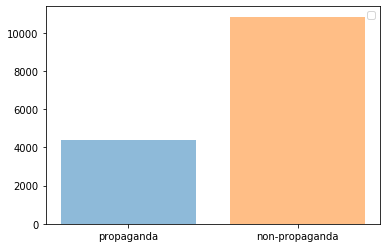

In [187]:
import random
import numpy
from matplotlib import pyplot

non_prop = df_1[df_1['propaganda'] == 'non-propaganda']
prop = df_1[df_1['propaganda']== 'propaganda']

x_1 = len(prop)
x_2 = len(non_prop)



pyplot.bar(x = 'propaganda' , height = x_1, alpha=0.5)
pyplot.bar(x = 'non-propaganda', height= x_2, alpha=0.5)
pyplot.legend(loc='upper right')
# pyplot.show()

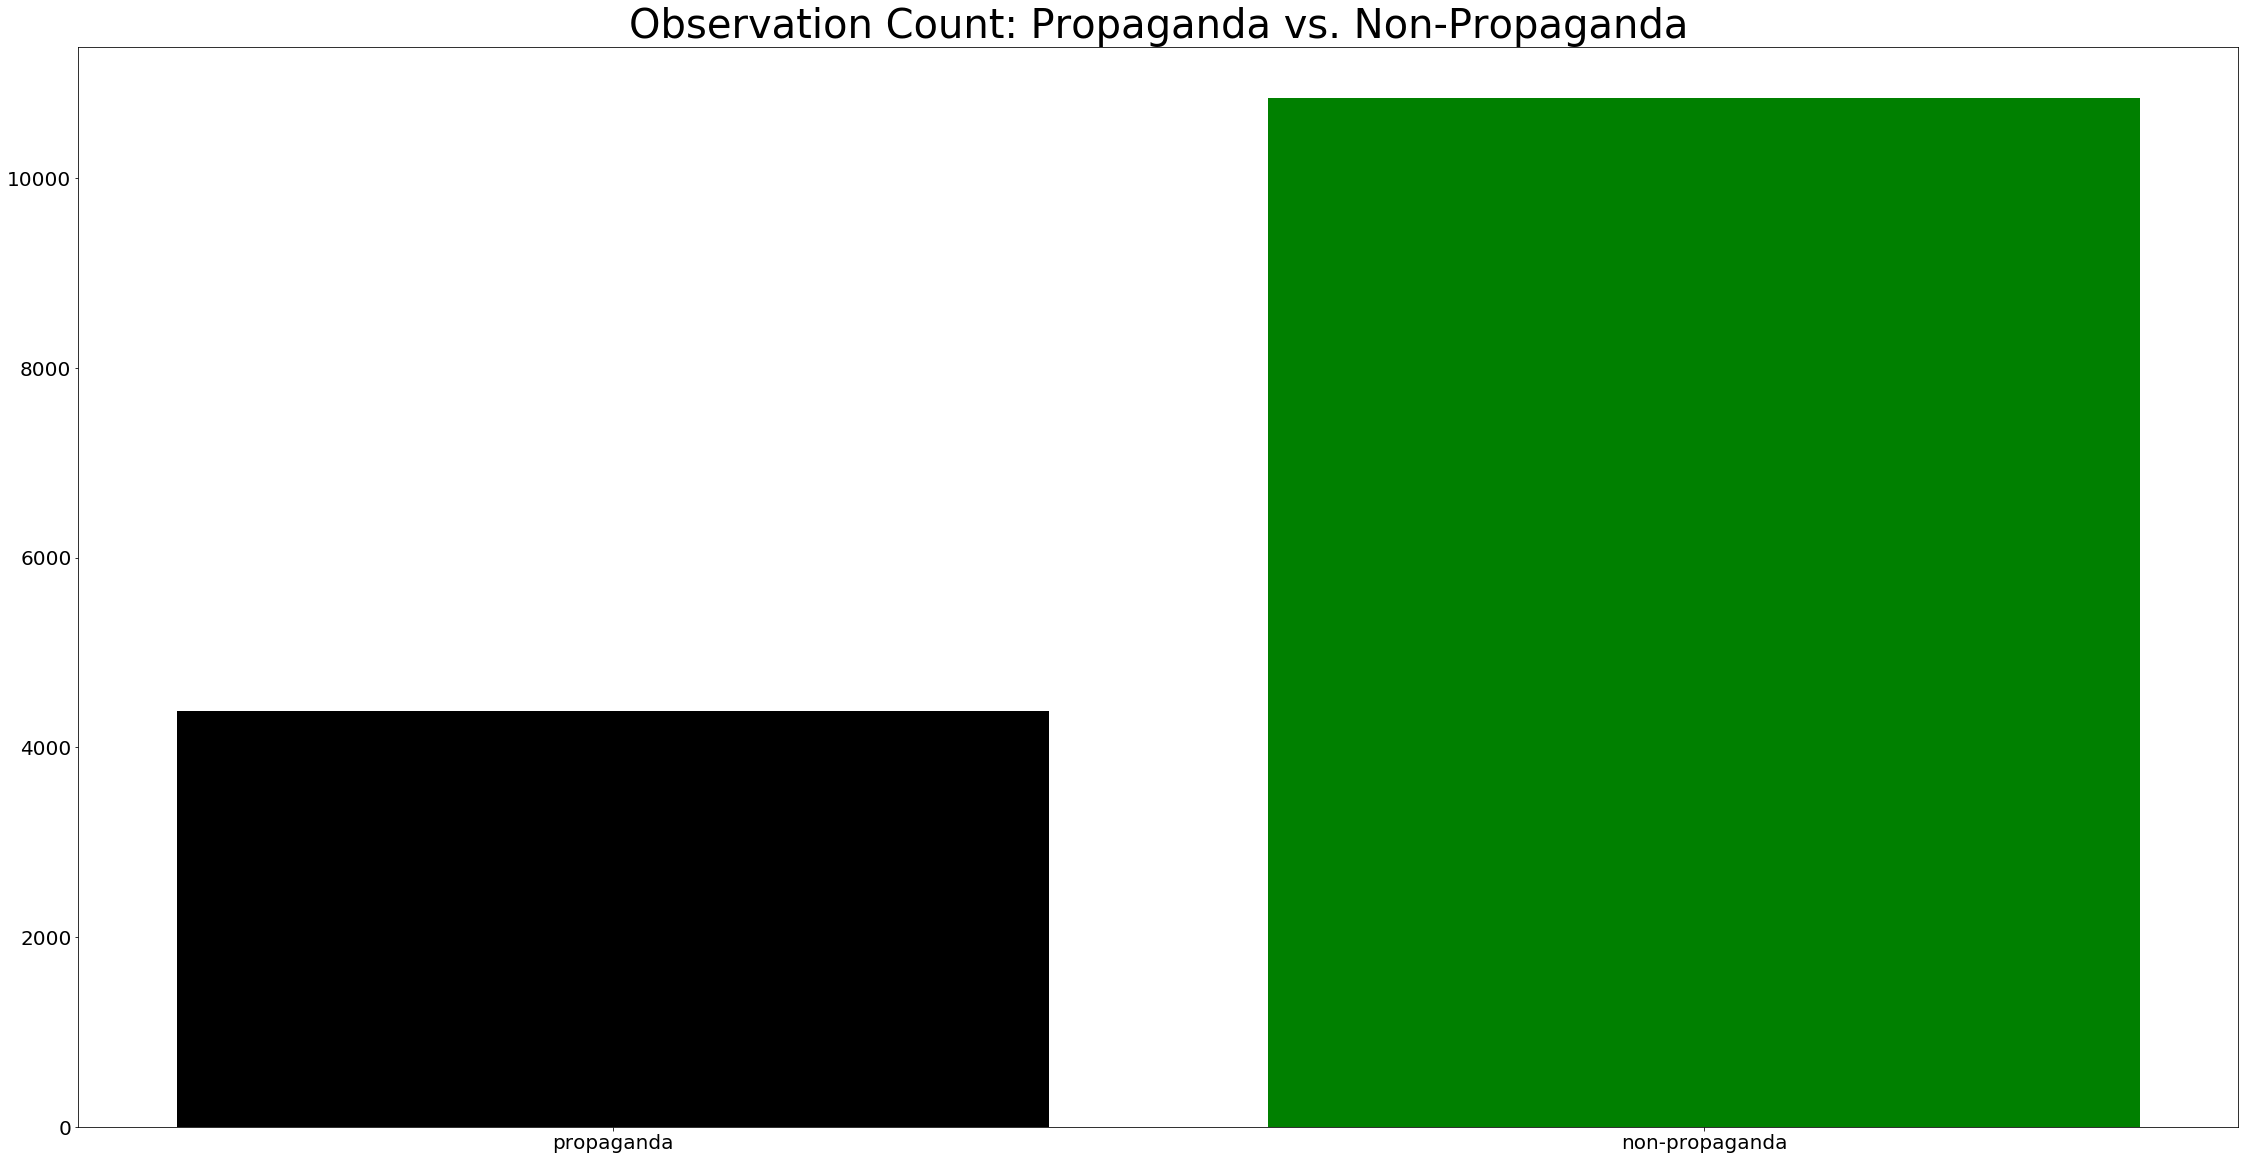

In [255]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,15))
ax = fig.add_axes([0,0,1,1])
labels = ['propaganda','non-propaganda']
heights = [x_1,x_2]
ax.bar(labels,heights,color=['black', 'green'])
plt.title('Observation Count: Propaganda vs. Non-Propaganda', fontsize=40)

plt.rc('xtick', labelsize=30)     
plt.rc('ytick', labelsize=30)
plt.show()

In [256]:
prop['propaganda_type'] = ['Unlabeled' if type(prop)==np.float else prop for prop in prop['propaganda_type']]

/Users/sashaepelbaum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [263]:
labels_1 = prop.propaganda_type.unique()
heights_1 = [len(prop[prop['propaganda_type']==type_]) for type_ in prop_types]
# prop_types_labels = ['Unlabeled' if type(type_)==np.float else type_ for type_ in prop_types]
print(labels_1,heights_1)

['Name_Calling,Labeling' 'Loaded_Language' 'Appeal_to_fear-prejudice'
 'Unlabeled' 'Slogans' 'Repetition' 'Whataboutism'
 'Causal_Oversimplification' 'Exaggeration,Minimisation' 'Doubt'
 'Thought-terminating_Cliches' 'Flag-Waving' 'Black-and-White_Fallacy'
 'Reductio_ad_hitlerum' 'Appeal_to_Authority' 'Red_Herring'
 'Obfuscation,Intentional_Vagueness,Confusion' 'Straw_Men' 'Bandwagon'] [681, 1394, 138, 540, 99, 369, 50, 125, 289, 317, 49, 140, 65, 36, 57, 9, 9, 7, 5]


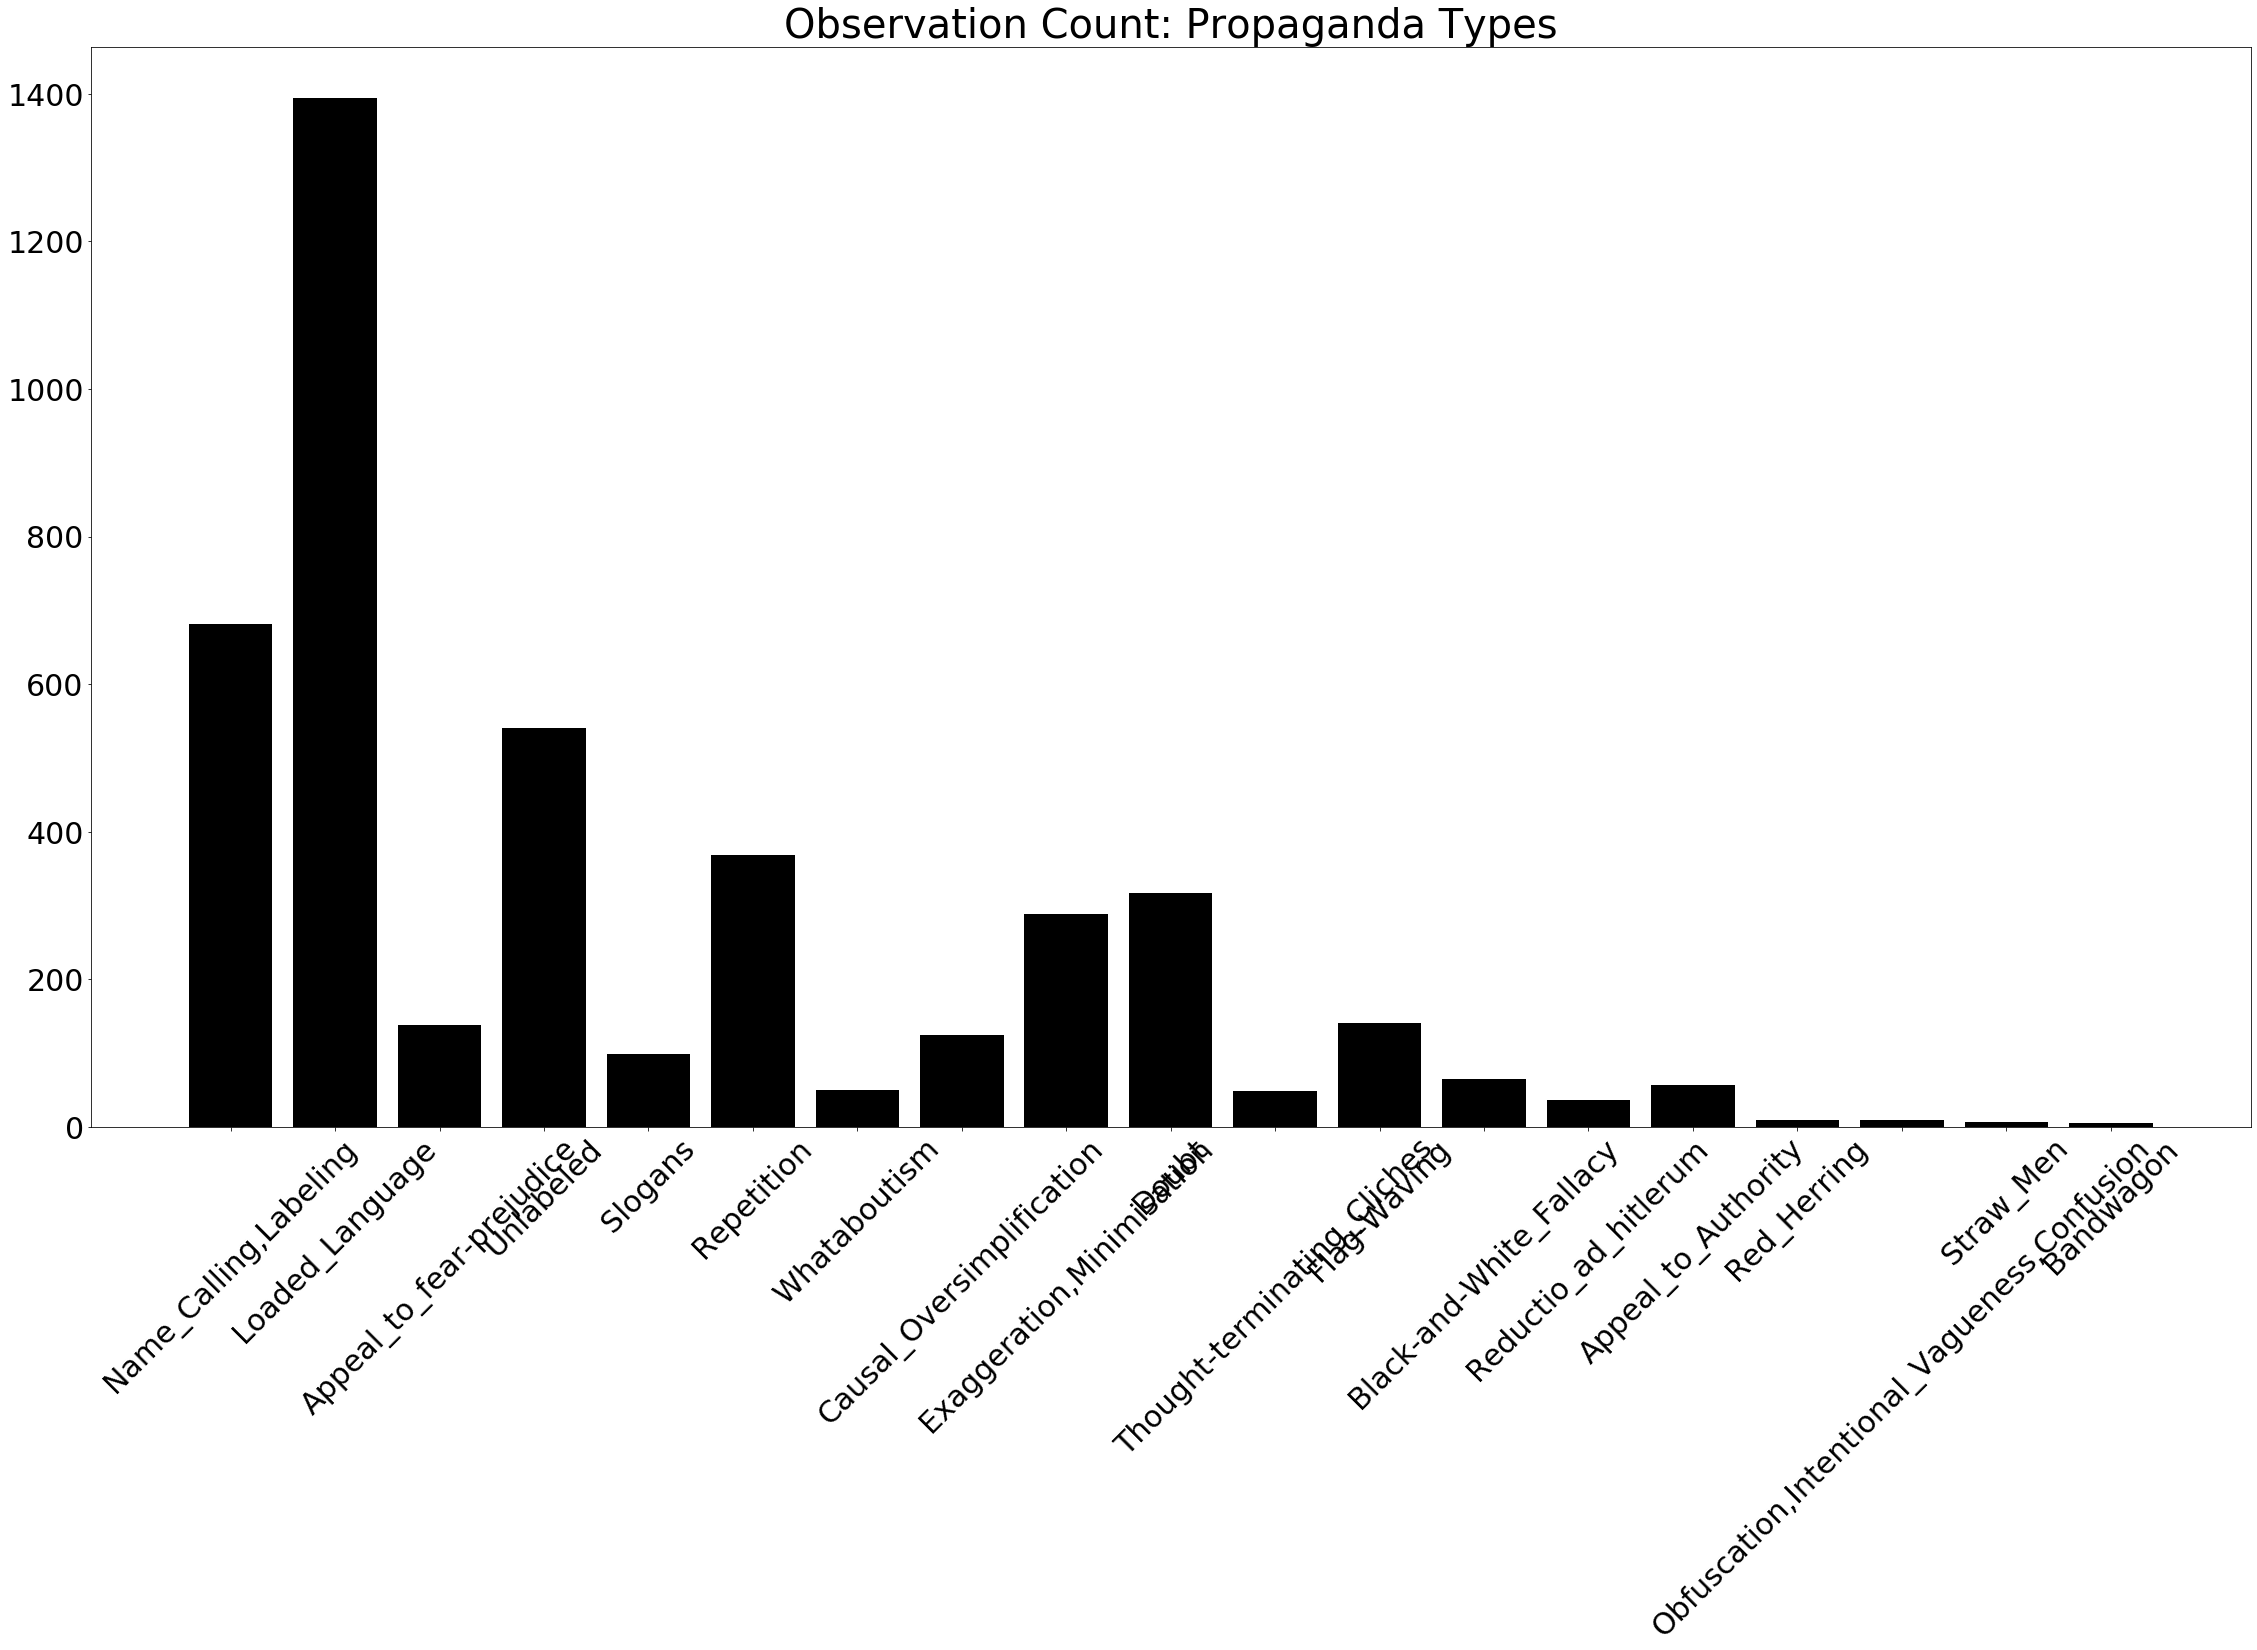

In [266]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,15))
ax = fig.add_axes([0,0,1,1])

ax.bar(labels_1,heights_1,color='black')
plt.title('Observation Count: Propaganda Types', fontsize=40)
plt.xticks(rotation=45)
plt.rc('xtick', labelsize=30)     
plt.rc('ytick', labelsize=30)
plt.show()


In [267]:
df_1.columns

Index(['Unnamed: 0', 'article_id', 'sentence_char_start', 'sentence_char_end', 'propaganda', 'propaganda_type', 'text', 'prop_start_char', 'prop_end_char', 'prop_txt_snippet', 'sent_#', 'sentiment_score', 'punct_count', 'word_count', 'avg_word_length'], dtype='object')

In [340]:
avg_prop_sent = prop['sentiment_score'].mean()
avg_non_prop_sent = non_prop['sentiment_score'].mean()
print(avg_prop_sent,avg_non_prop_sent)

-0.11065090203242749 0.0029635089013928403


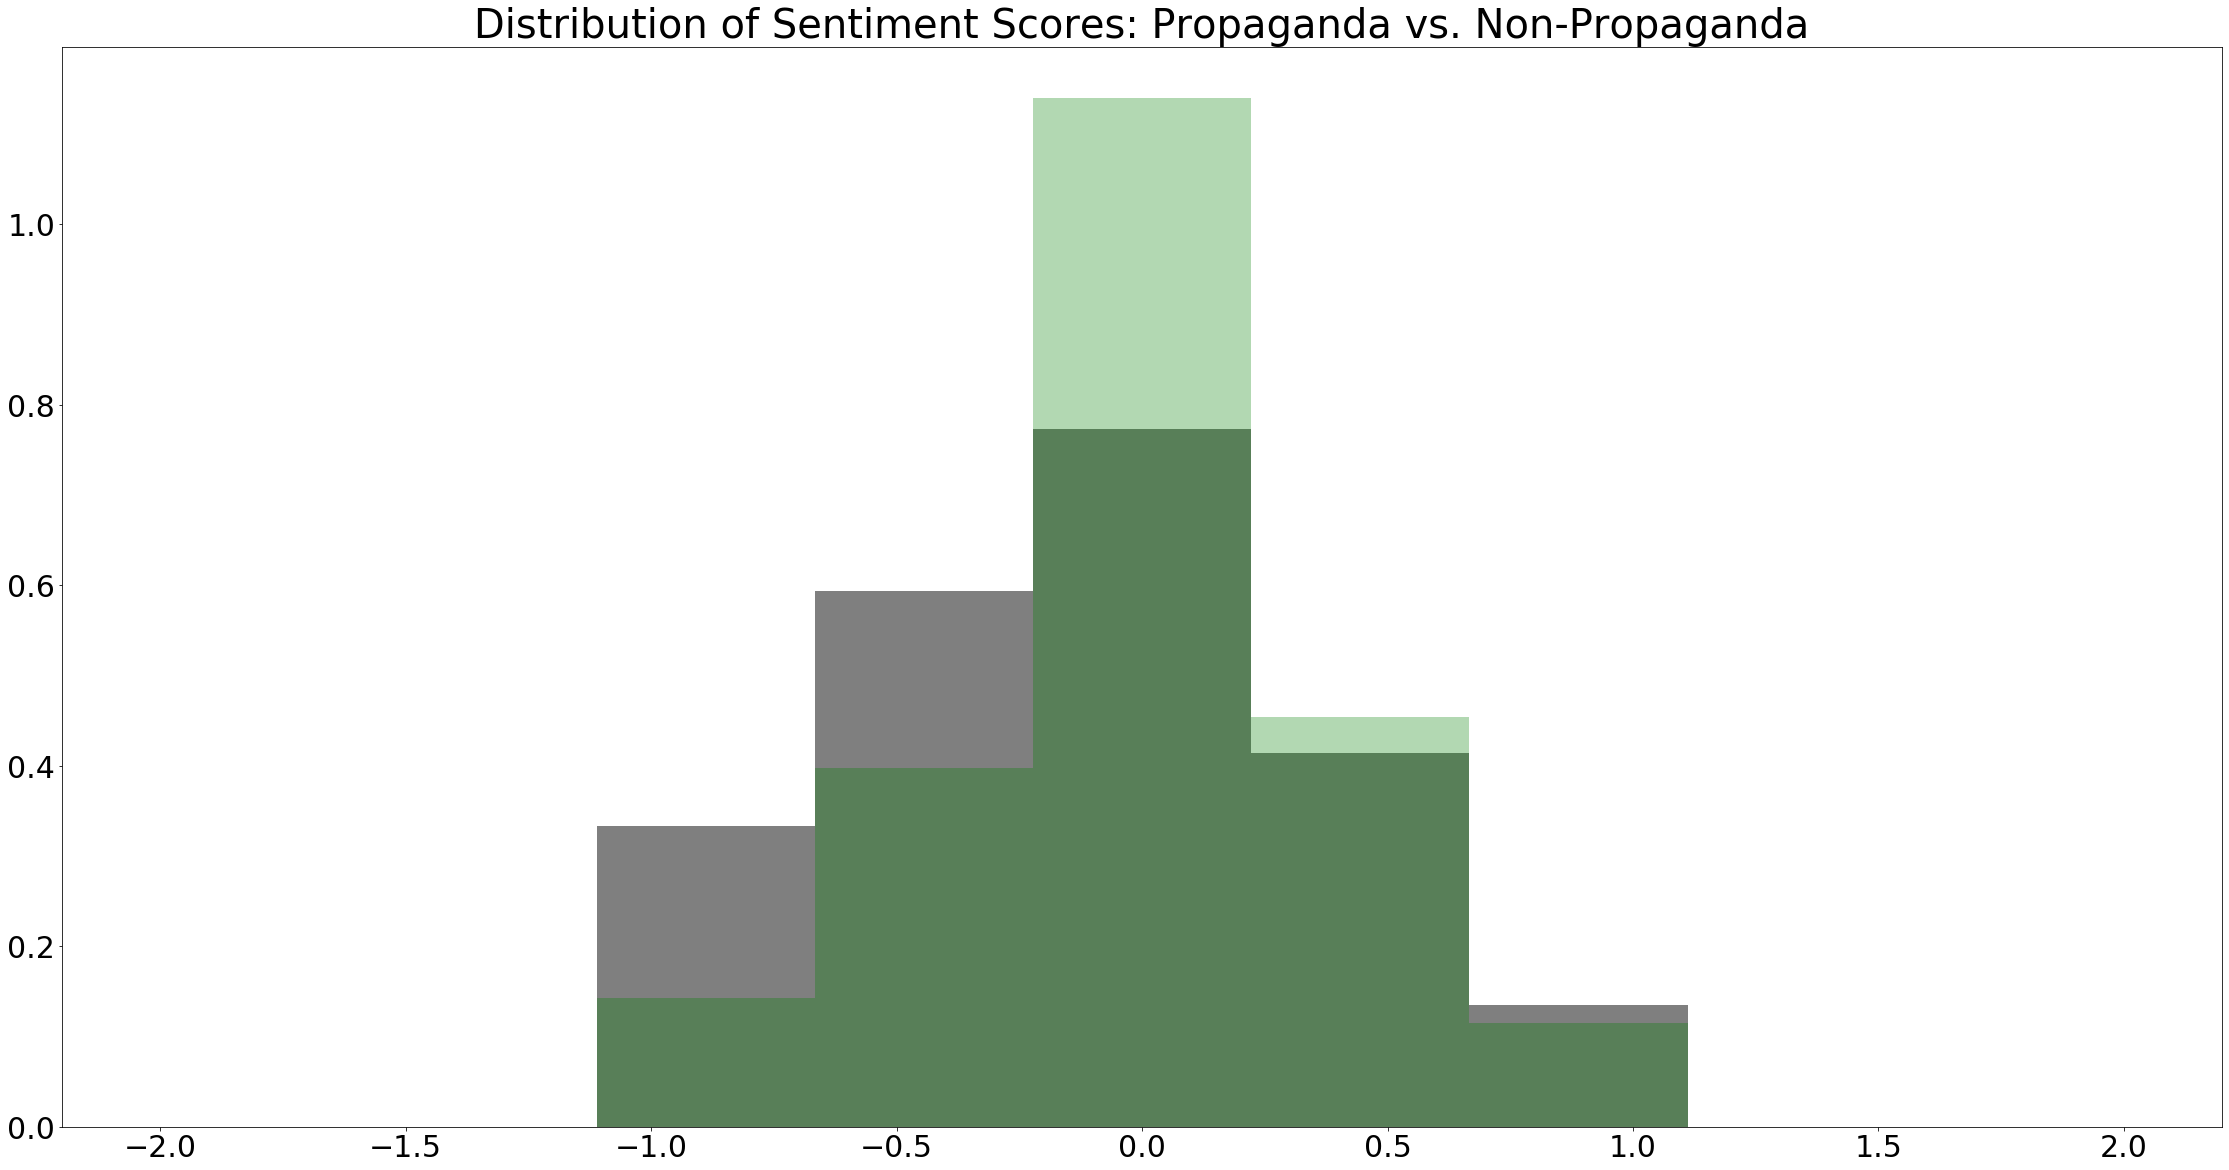

In [386]:

from matplotlib import pyplot
fig_2 = plt.figure(figsize=(30,15))

ax_2 = fig_2.add_axes([0,0,1,1])
bins = numpy.linspace(-2, 2, 10)
prop_sent = prop['sentiment_score'].get_values()
non_prop_sent = non_prop['sentiment_score'].get_values()

plt.hist(prop_sent, bins, alpha=0.5, label='Propaganda', color='black', density=True)
plt.hist(non_prop_sent, bins, alpha=0.3, label='Non-Propaganda', color='green', density=True)
plt.title('Distribution of Sentiment Scores: Propaganda vs. Non-Propaganda', fontsize=40)
# plt.legend(loc='upper right', fontsize=30)
plt.show()

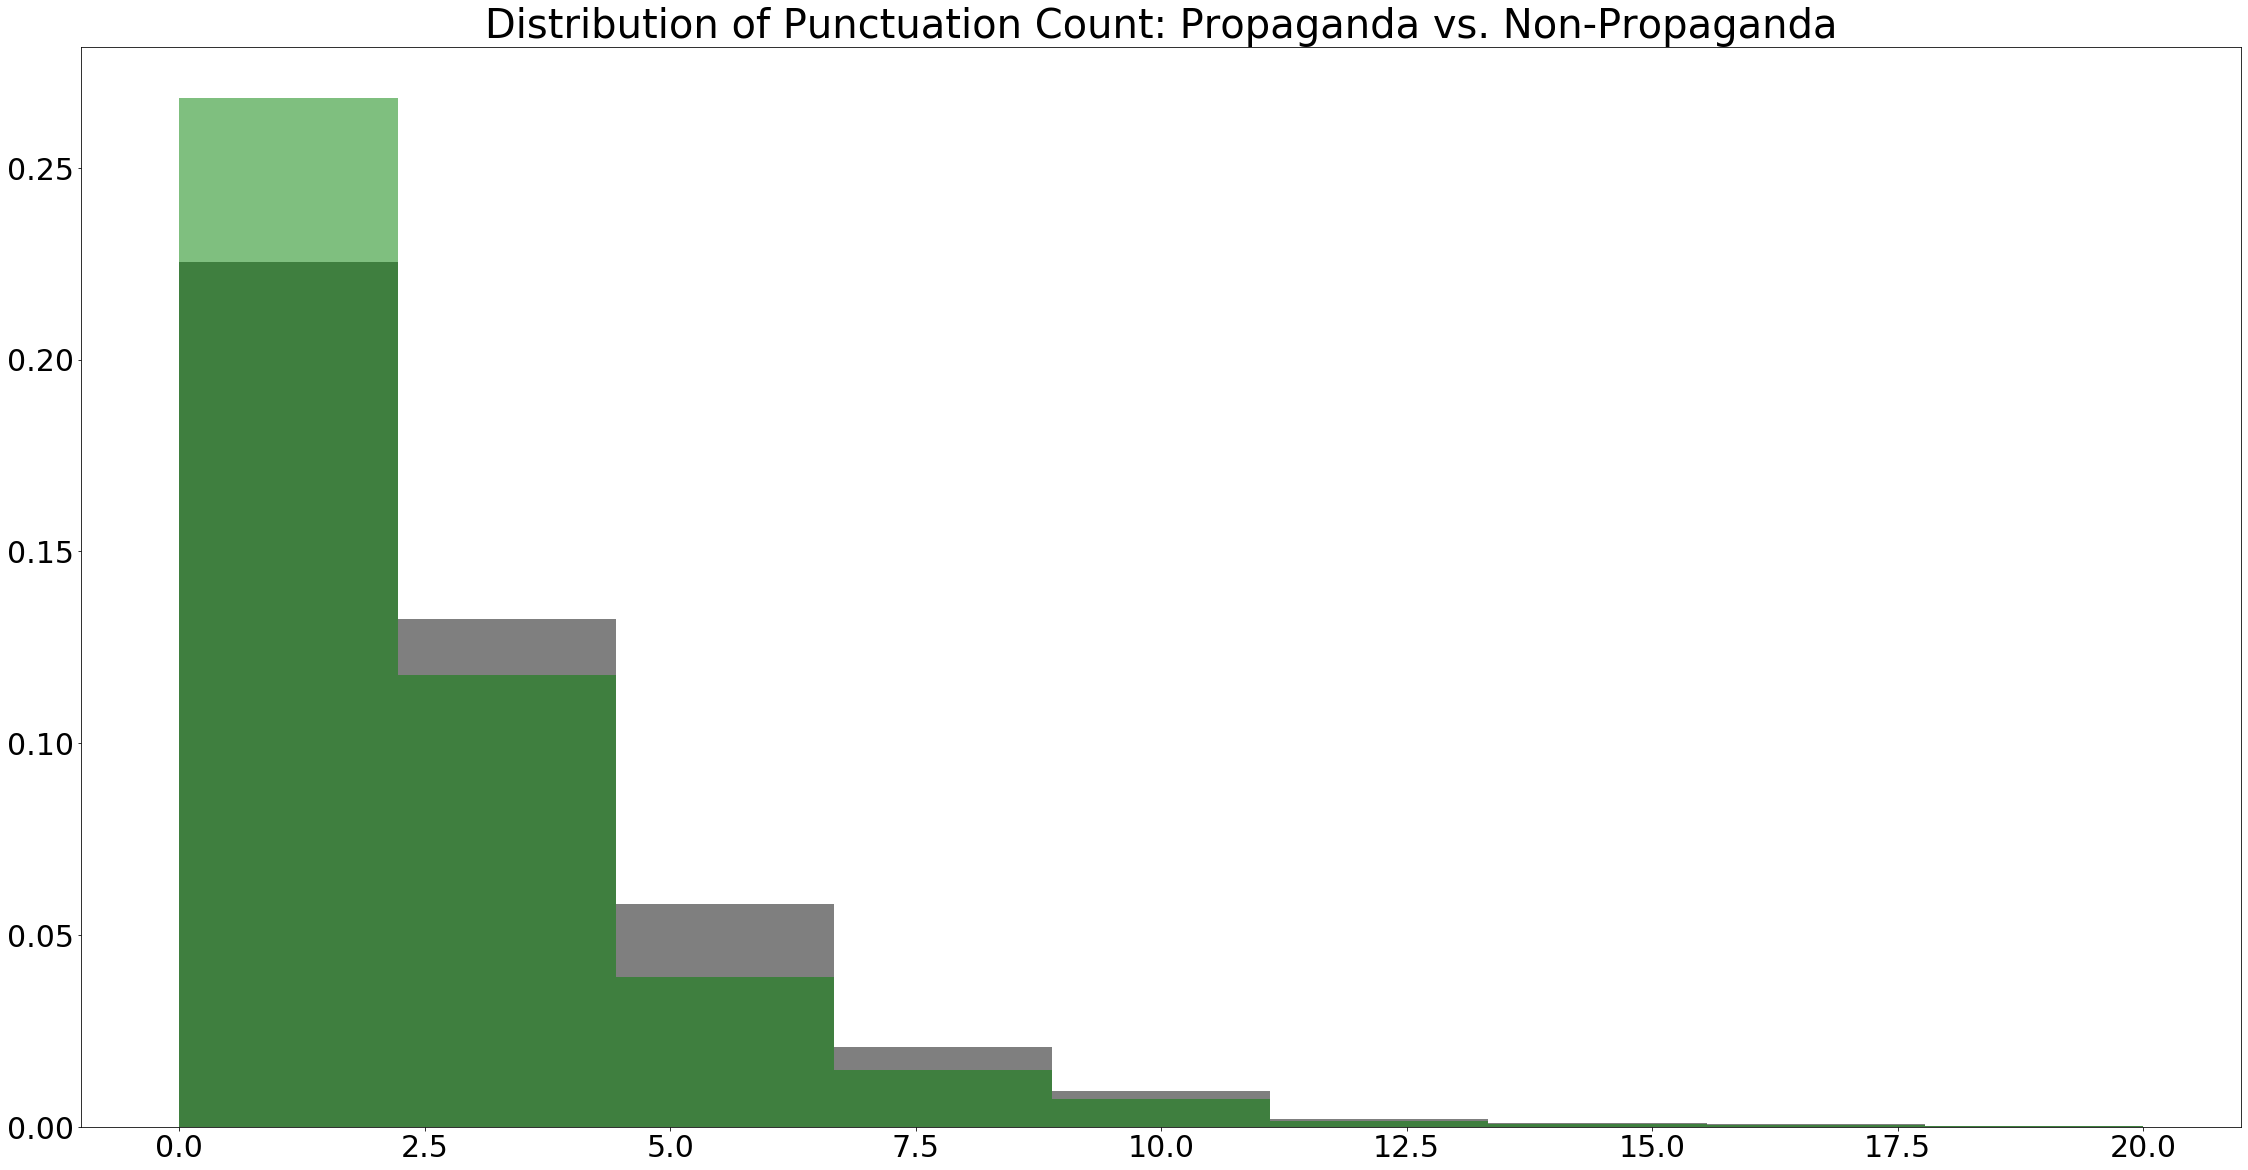

In [382]:
from matplotlib import pyplot
fig_2 = plt.figure(figsize=(30,15))

ax_2 = fig_2.add_axes([0,0,1,1])
bins = numpy.linspace(0, 20, 10)
prop_punct_count = prop['punct_count'].get_values()
non_prop_punct_count = non_prop['punct_count'].get_values()

plt.hist(prop_punct_count, bins, alpha=0.5, label='Propaganda', color='black', density=True)
plt.hist(non_prop_punct_count, bins, alpha=0.5, label='Non-Propaganda', color='green', density=True)
plt.title('Distribution of Punctuation Count: Propaganda vs. Non-Propaganda', fontsize=40)
# plt.legend(loc='upper right', fontsize=30)
plt.show()

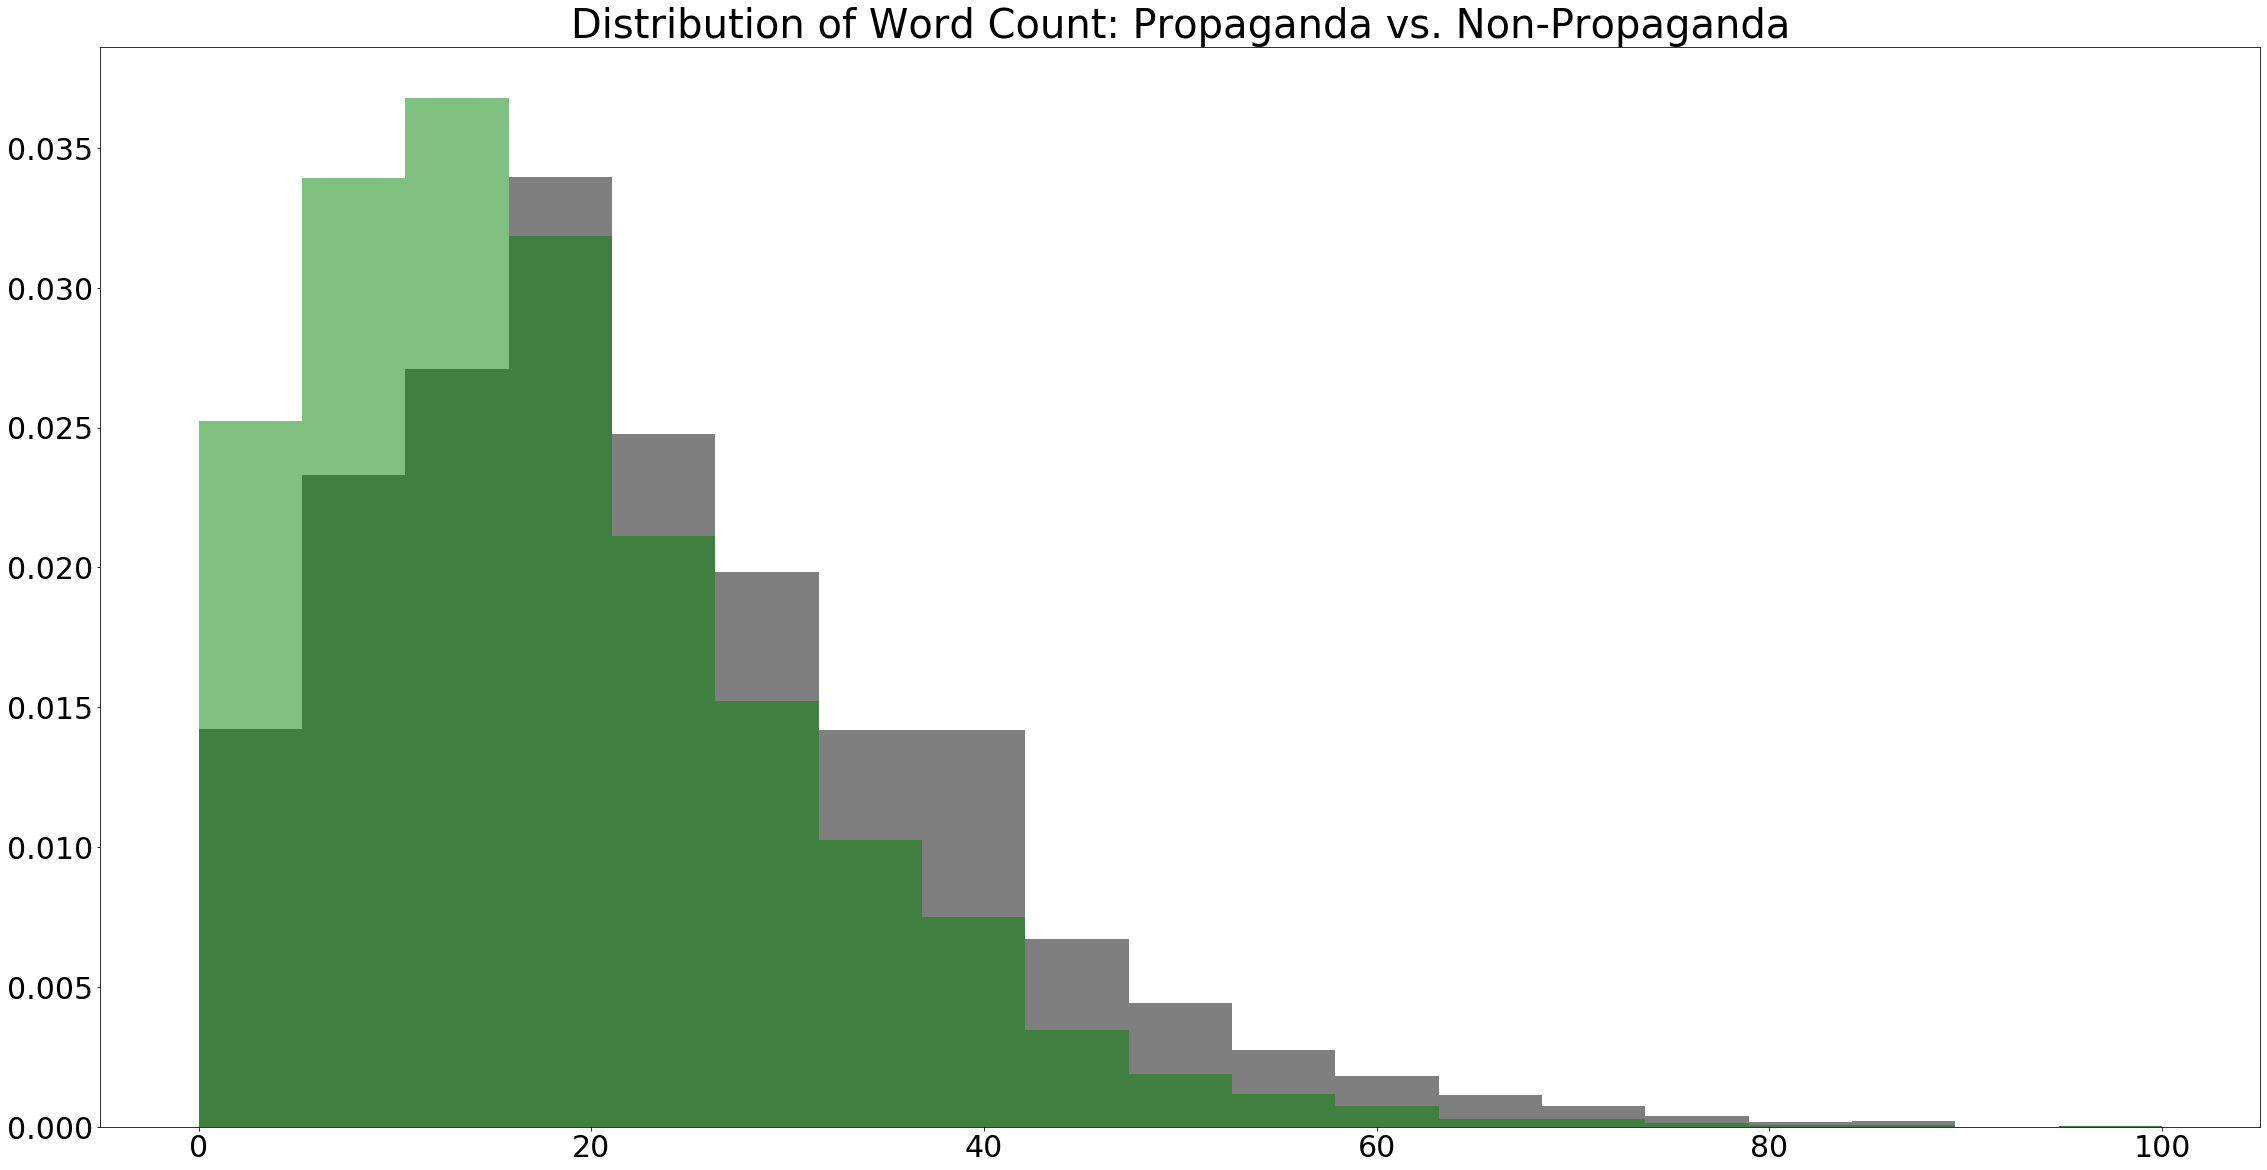

In [383]:
from matplotlib import pyplot
fig_2 = plt.figure(figsize=(30,15))

ax_2 = fig_2.add_axes([0,0,1,1])
bins = numpy.linspace(0, 100, 20)
prop_wc = prop['word_count'].get_values()
non_prop_wc = non_prop['word_count'].get_values()

plt.hist(prop_wc, bins, alpha=0.5, label='Propaganda', color='black',density=True)
plt.hist(non_prop_wc, bins, alpha=0.5, label='Non-Propaganda', color='green',density=True)
plt.title('Distribution of Word Count: Propaganda vs. Non-Propaganda', fontsize=40)
# plt.legend(loc='upper right', fontsize=30)
plt.show()

In [338]:
avg_prop_wc = np.mean(prop['word_count'])
avg_non_prop_wc = np.mean(non_prop['word_count'])
print(avg_prop_wc,avg_non_prop_wc)

23.225393925553778 17.928881099529562


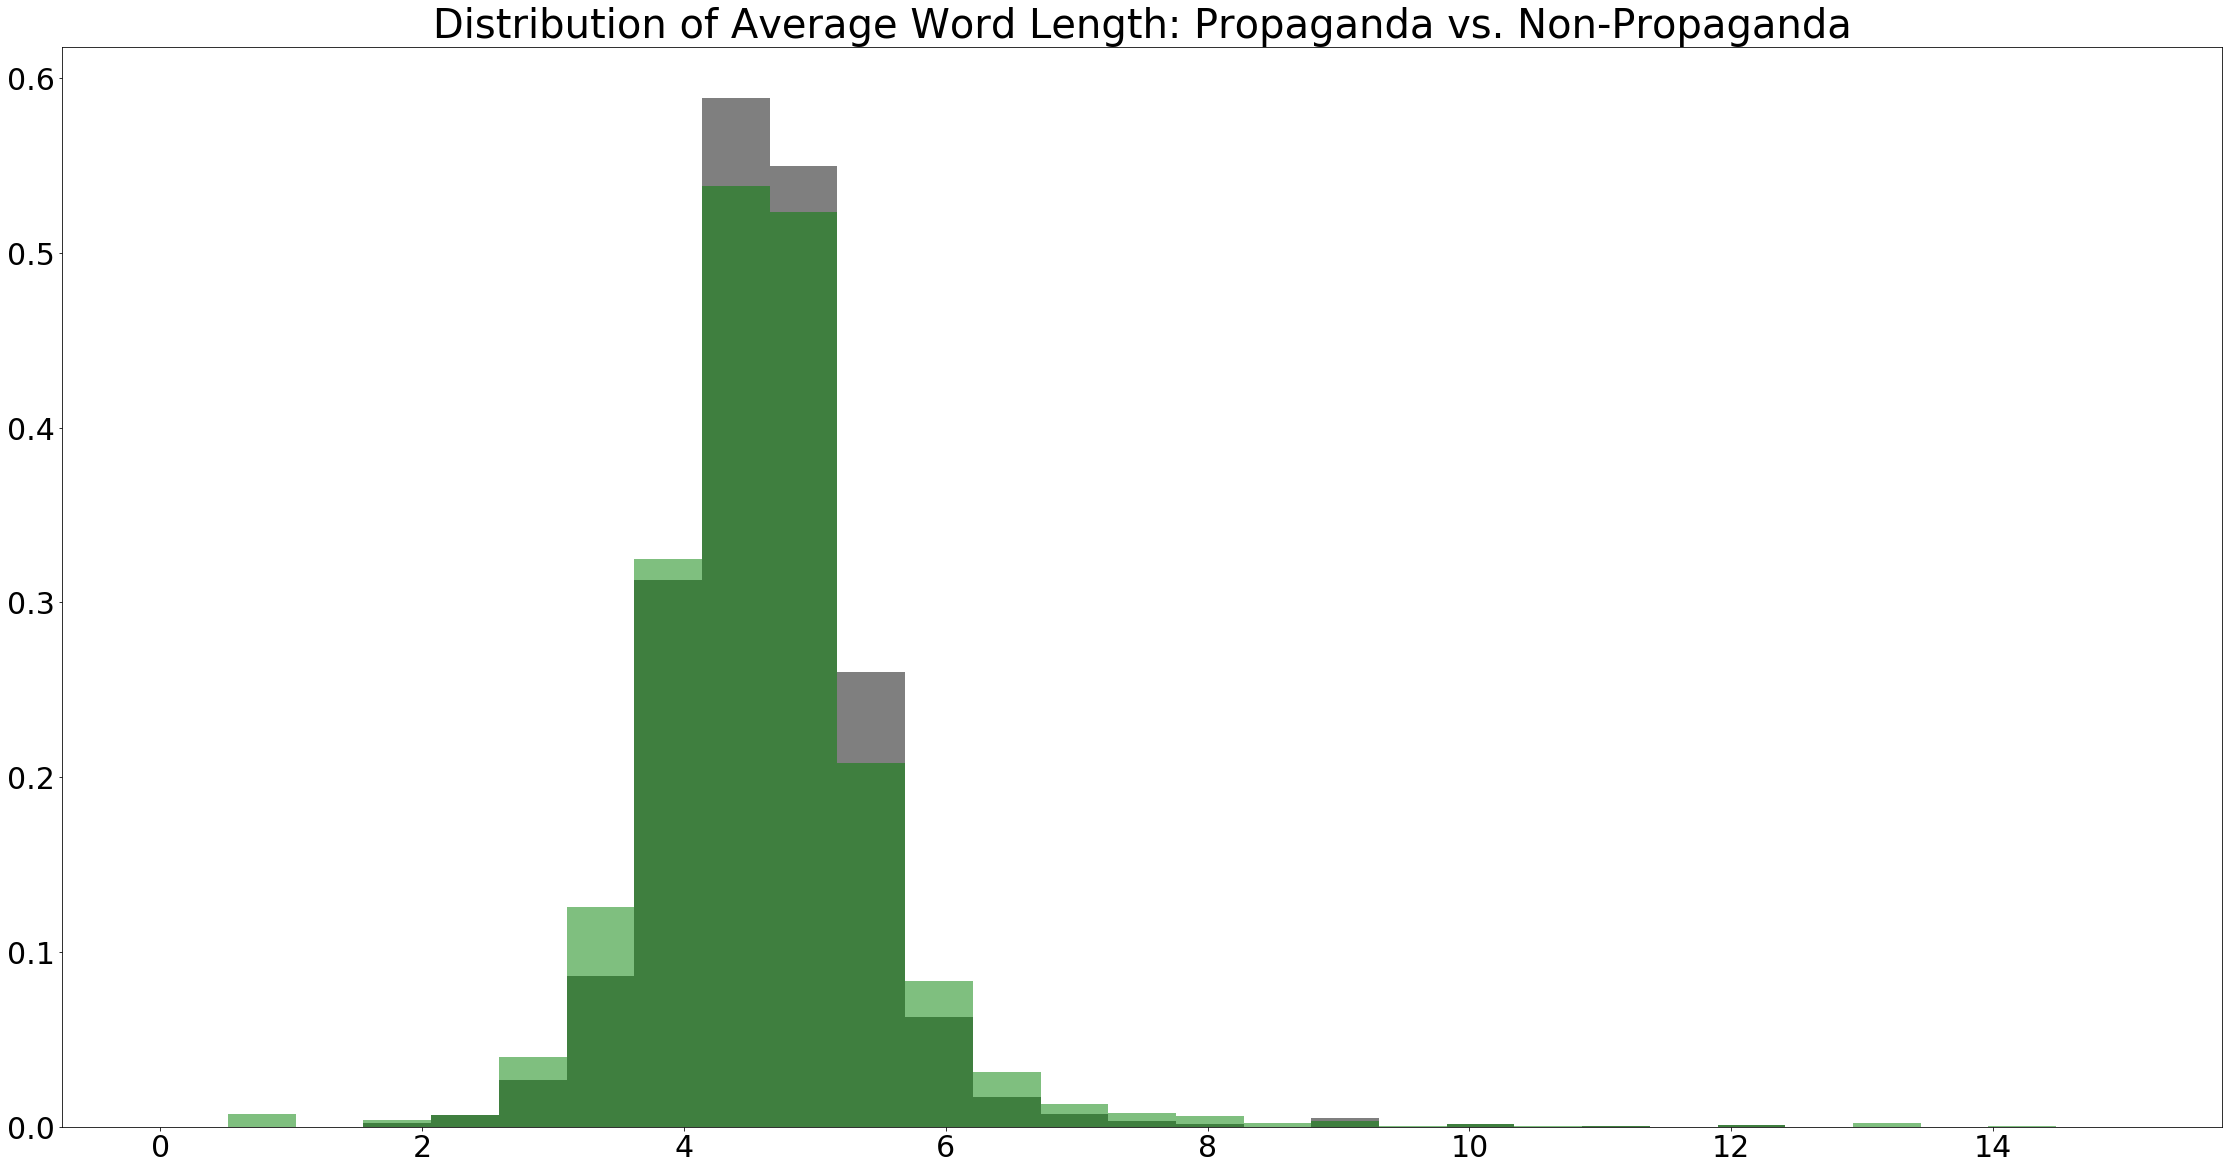

In [384]:
from matplotlib import pyplot
fig_2 = plt.figure(figsize=(30,15))

ax_2 = fig_2.add_axes([0,0,1,1])
bins = numpy.linspace(0, 15, 30)
prop_wl = prop['avg_word_length'].get_values()
non_prop_wl = non_prop['avg_word_length'].get_values()

plt.hist(prop_wl, bins, alpha=0.5, label='Propaganda', color='black',density=True)
plt.hist(non_prop_wl, bins, alpha=0.5, label='Non-Propaganda', color='green',density=True)
plt.title('Distribution of Average Word Length: Propaganda vs. Non-Propaganda', fontsize=40)
# plt.legend(loc='upper right', fontsize=30)
plt.show()

## Most Common Words

### Most Common Words Corpus-Wide : Words to Add to STOP_WORDS

In [409]:
def simple_tokenizer_2(text):
    text = replace_contractions(text,contr_dict)
    mytokens = nlp(text)
#     mytokens = [word for word in mytokens if (word.pos_ == "ADJ" or "ADV"or "VERB")]
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [word for word in mytokens if word not in punctuation]
    mytokens = [ word for word in mytokens if word not in stop_words]
    return mytokens

In [410]:
list_tokenized_text = df_1['text'].apply(lambda x: simple_tokenizer_2(x))

In [411]:

tokenized_text = []
for text in list_tokenized_text:
    tokenized_text.extend(text)

In [412]:
from collections import Counter
tokenized_text_counts = Counter(tokenized_text)
top_100_3 = tokenized_text_counts.most_common(50)


top_100_stops_3 = {tup[0] for tup in top_100}

In [413]:
top_100_stops_3

{'abuse',
 'accord',
 'american',
 'anti',
 'ask',
 'assange',
 'attack',
 'authority',
 'believe',
 'bishop',
 'border',
 'cardinal',
 'case',
 'catholic',
 'change',
 'charge',
 'cia',
 'claim',
 'clinton',
 'come',
 'confirm',
 'consider',
 'continue',
 'country',
 'court',
 'day',
 'department',
 'document',
 'donot',
 'election',
 'email',
 'evidence',
 'fact',
 'fbi',
 'find',
 'force',
 'ford',
 'francis',
 'free',
 'god',
 'good',
 'government',
 'group',
 'gun',
 'history',
 'house',
 'include',
 'investigation',
 'iran',
 'issue',
 'judge',
 'justice',
 'kavanaugh',
 'law',
 'leave',
 'letter',
 'life',
 'like',
 'long',
 'man',
 'mccarrick',
 'medium',
 'member',
 'month',
 'new',
 'news',
 'obama',
 'official',
 'order',
 'place',
 'point',
 'post',
 'president',
 'priest',
 'public',
 'question',
 'release',
 'report',
 'right',
 'school',
 'state',
 'statement',
 'story',
 'tell',
 'thing',
 'think',
 'u.s.',
 'united',
 'use',
 'vatican',
 'vegas',
 'victim',
 'want',
 '

In [394]:
top_50_stops_2

{'abuse',
 'american',
 'ask',
 'attack',
 'bishop',
 'cardinal',
 'case',
 'catholic',
 'claim',
 'clinton',
 'come',
 'continue',
 'country',
 'court',
 'day',
 'email',
 'fact',
 'fbi',
 'francis',
 'god',
 'good',
 'government',
 'gun',
 'house',
 'include',
 'investigation',
 'kavanaugh',
 'law',
 'life',
 'like',
 'man',
 'new',
 'official',
 'order',
 'president',
 'public',
 'report',
 'right',
 'state',
 'story',
 'tell',
 'think',
 'u.s.',
 'use',
 'want',
 'work',
 'world',
 'write',
 '–',
 '…'}

In [389]:
top_50_stops

{'abuse',
 'american',
 'ask',
 'attack',
 'bishop',
 'cardinal',
 'case',
 'catholic',
 'claim',
 'clinton',
 'come',
 'continue',
 'country',
 'court',
 'day',
 'email',
 'fact',
 'fbi',
 'francis',
 'god',
 'good',
 'government',
 'gun',
 'house',
 'include',
 'investigation',
 'kavanaugh',
 'law',
 'life',
 'like',
 'man',
 'new',
 'official',
 'order',
 'president',
 'public',
 'report',
 'right',
 'state',
 'story',
 'tell',
 'think',
 'u.s.',
 'use',
 'want',
 'work',
 'world',
 'write',
 '–',
 '…'}

In [414]:
## ADDING WORDS TO STOPWORDS

import spacy    

nlp.Defaults.stop_words |= {"trump","church","pope","—","people","know","time","year"}
nlp.Defaults.stop_words |= top_50_stops
nlp.Defaults.stop_words |= top_50_stops_2
nlp.Defaults.stop_words |= top_100_stops_3

In [396]:
stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'abuse',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'american',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'ask',
 'at',
 'attack',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bishop',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'cardinal',
 'case',
 'catholic',
 'church',
 'claim',
 'clinton',
 'come',
 'continue',
 'could',
 'country',
 'court',
 'day',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'email',
 'empty',
 'enough',
 'even',
 'eve

In [397]:
simple_tokenizer_2('She cried furiously when she went to the zoo and saw the state church.')

['cry', 'furiously', 'zoo']

### Applying tokenizer to propaganda and non-propaganda text

In [398]:
#non-noun tokenizer
def simple_tokenizer_3(text):
    text = replace_contractions(text,contr_dict)
    mytokens = nlp(text)
    mytokens = [word for word in mytokens if (word.pos_ == "ADJ" or "ADV"or "VERB")]
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [word for word in mytokens if word not in punctuation]
    mytokens = [ word for word in mytokens if word not in stop_words]
    return mytokens

In [415]:
simple_tokenized_prop = prop['text'].apply(lambda text: simple_tokenizer_2(text))
simple_tokenized_non_prop = non_prop['text'].apply(lambda text: simple_tokenizer_2(text))

In [416]:
prop_word_list = []
for x in simple_tokenized_prop:
    prop_word_list.extend(x)
    
non_prop_word_list = []
for x in simple_tokenized_non_prop:
    non_prop_word_list.extend(x)
    
print(type(prop_word_list),type(non_prop_word_list))
    

<class 'list'> <class 'list'>


In [417]:
from collections import Counter
prop_word_counts = Counter(prop_word_list)
prop_top_200 = prop_word_counts.most_common(200)
print(prop_top_200)

[('homosexual', 81), ('guardian', 81), ('america', 79), ('war', 78), ('muslim', 74), ('great', 72), ('bad', 70), ('bergoglio', 70), ('jews', 68), ('power', 67), ('truth', 66), ('lie', 65), ('act', 65), ('happen', 65), ('sexual', 62), ('lead', 61), ('jewish', 60), ('death', 60), ('word', 60), ('administration', 59), ('woman', 56), ('democrats', 56), ('face', 55), ('russia', 55), ('look', 54), ('national', 53), ('support', 53), ('community', 52), ('political', 52), ('cover', 52), ('student', 52), ('islam', 52), ('vote', 52), ('jihad', 52), ('need', 52), ('record', 52), ('stop', 52), ('criminal', 51), ('deal', 51), ('attorney', 50), ('old', 50), ('note', 49), ('general', 49), ('viganò', 49), ('kill', 48), ('washington', 48), ('attempt', 48), ('control', 48), ('try', 48), ('follow', 48), ('page', 47), ('big', 47), ('crime', 47), ('allow', 47), ('course', 47), ('head', 47), ('julian', 47), ('regime', 47), ('leader', 46), ('reason', 46), ('destroy', 46), ('archbishop', 46), ('europe', 46), (

In [418]:
from collections import Counter
non_prop_word_counts = Counter(non_prop_word_list)
non_prop_top_200 = non_prop_word_counts.most_common(200)
print(non_prop_top_200)

[('poll', 141), ('las', 130), ('paddock', 129), ('shooting', 122), ('article', 121), ('access', 120), ('speak', 119), ('police', 119), ('2018', 119), ('policy', 119), ('term', 118), ('federal', 112), ('send', 112), ('information', 111), ('states', 111), ('follow', 110), ('national', 109), ('try', 109), ('vote', 109), ('need', 108), ('security', 106), ('agree', 106), ('support', 105), ('number', 105), ('person', 105), ('supreme', 105), ('receive', 104), ('add', 104), ('committee', 104), ('2017', 103), ('didnot', 102), ('begin', 101), ('office', 101), ('clear', 101), ('note', 100), ('party', 99), ('2016', 98), ('october', 98), ('john', 98), ('end', 98), ('complete', 97), ('council', 97), ('deal', 97), ('help', 96), ('record', 95), ('grant', 95), ('cover', 93), ('high', 92), ('stop', 92), ('happen', 92), ('freedom', 92), ('fire', 92), ('haig', 92), ('pass', 91), ('meeting', 91), ('student', 91), ('washington', 90), ('allow', 90), ('matter', 89), ('democrat', 89), ('home', 89), ('hold', 88

### Tokenizing

In [ ]:
# Creating our tokenizer function
def spacy_tokenizer(text):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(text)
#     mytokens = [word for word in mytokens if word.pos_ != "PROPN"]
#     mytokens = [ word if word.pos_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens
